In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import copy
import warnings
import seaborn as sns


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from statistics import mean 
from matplotlib import cm
from matplotlib.font_manager import FontProperties
from torch import optim
from sklearn import cluster


warnings.filterwarnings("ignore")
%matplotlib ipympl

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(12)
font.set_weight('bold')

In [2]:
class Net(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.l1 = nn.Flatten()
        self.l2 = nn.LazyLinear(32)
        self.l3 = nn.ReLU()
        self.l4 = nn.LazyLinear(32)
        self.l5 = nn.ReLU()
        # out strain
        self.l6 = nn.LazyLinear(1)
        # out stress
        self.l7 = nn.LazyLinear(20)

    def forward(self, X, rd=True):
        o1 = self.l1(X)
        o2 = self.l2(o1)
        o3 = self.l3(o2)
        o4 = self.l4(o3)
        o5 = self.l5(o4)
        if rd:
            o6 = self.l6(F.dropout(o5,p=.1))
            o7 = self.l7(F.dropout(o5,p=.2))
        else:
            o6 = self.l6(o5)
            o7 = self.l7(o5)
        return o6, o7

In [3]:
def scale(scale_method, df, target_start, output):
    df_scaled = pd.DataFrame(scale_method.fit_transform(df.iloc[:,:target_start]))
    df_scaled.columns = df.columns[:target_start]
    df_scaled[output] = df[output]
    return df_scaled, scale_method

In [4]:
def plt_curve(loss):
    plt.figure(figsize=(4,3))
    if len(loss) == 1:
        plt.plot(loss[0][0], '-', label='train_loss')
        plt.plot(loss[0][1], '--', label='val_loss')
    else:
        plt.plot(loss[0][0], '-', label='train_loss (SSTL)')
        plt.plot(loss[0][1], '--', label='val_loss (SSTL)')
        plt.plot(loss[1][0], '-.', label='train_loss (DNN)')
        plt.plot(loss[1][1], ':', label='val_loss (DNN)')
    plt.xlabel('epoch')
    plt.ylabel('MSEloss')
    plt.legend()
    plt.show

In [5]:
def fit(epochs, model, loss_func, opt, train_ds, valid_ds, bs, X_train, y_train, X_val, y_val, temp):
    model_loss = [[], []]
    
    for epoch in range(epochs):
        old_m = copy.deepcopy(model)
        old_l = model_loss
        train_loss = 0
        valid_loss = 0
        
        train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
        
        model.train()
        train_loss = loss_batch(model, loss_func, train_dl, temp, opt)
        model_loss[0].append(train_loss.item())
        
        model.eval()
        valid_loss = loss_batch(model, loss_func, valid_dl, temp, opt=None)
        model_loss[1].append(valid_loss.item())
        
        if epoch < 10:
            continue
        elif (model_loss[1][-1]-model_loss[1][-2])/model_loss[1][-1] > 0:
            print('up')
            return old_l, old_m
        elif (model_loss[1][-1]-model_loss[1][-2])/model_loss[1][-1] < -1e-2:
            continue
        else:
            print('stable')
            return model_loss, model

In [6]:
def loss_batch(model, loss_func, dl, temp, opt=None):
    
    for xb, yb in dl:
        loss1 = loss_func(model(xb,rd=False)[0] , yb[:, 0]) 
        loss2 = loss_func(model(xb,rd=False)[1], yb[:, 1:]) * temp
        loss = loss1 + loss2
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss

In [7]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True),
        DataLoader(valid_ds, batch_size=bs * 2, drop_last=True),
    )

In [8]:
def split_data(train_data_scaled, target):
    X = train_data_scaled[train_data_scaled.columns[:10]]
    y = train_data_scaled[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
    X_train_val = torch.tensor(X_train.values).float()
    y_train_val = torch.tensor(y_train.values).float()
    X_val_val = torch.tensor(X_val.values).float()
    y_val_val = torch.tensor(y_val.values).float()
    train_ds = TensorDataset(X_train_val, y_train_val)
    valid_ds = TensorDataset(X_val_val, y_val_val)
    return train_ds, valid_ds, X_train_val, y_train_val, X_val_val, y_val_val

In [9]:
def df_group(df, groups, ngroup):
    df_feature = df[groups]
    k_means = cluster.KMeans(n_clusters=ngroup, max_iter=50, random_state=1)
    k_means.fit(df_feature) 
    labels = k_means.labels_
    return df.insert(0, 'labels', labels, True)

In [10]:
def get_subdf(df, ngroup):
    if ngroup == 1:
        return [df]
    else:
        subdf = []
        for i in range(ngroup):
            t = df[df['labels'] == i].reset_index(drop=True)
            subdf.append(t.drop(columns='labels'))
        return subdf

In [11]:
def valid_plot(df, scaler, groups, group_id, ngroup, target, model, adj=1):

    sub_df = get_subdf(df, ngroup)

    if len(sub_df)>1:
        sub_df = sub_df[group_id]
    else:
        sub_df = sub_df[0]

    X = [sub_df.mean()[:10].tolist()]
    X[0][8] = X[0][8]*adj
    X =  torch.Tensor(scaler.transform(X))
    
    curve_x = np.zeros([len(sub_df['ecu'].values), 20])
    for i in range(curve_x.shape[0]):
        curve_x[i, :] = (1- np.cos(np.linspace(0,1, num=21)[1:] * np.pi / 2)) * sub_df['ecu'].values[i]
    curve_y = sub_df[target].iloc[:,1:].values
    
    n = int(np.max(curve_x)/0.02)
    x = np.arange(0, (n+1)*0.02, 0.02)[1:]
    y = np.zeros([1000, n*2])
    
    valid_x, valid_y = [], []

    # model.eval()
    for i in range(100):
        maxx = model(X)[0].detach().numpy()[0][0]
        valid_x.append((1-np.cos(np.linspace(0,1, num=21)[1:]*np.pi/2))*maxx)
        valid_y.append(model(X)[1].detach().numpy()[0])
        
    for j in range(100):
        nx = int(np.max(valid_x[j])/0.02)
        y[j,:len(np.interp(x[:nx], valid_x[j], valid_y[j]))] = np.interp(x[:nx], valid_x[j], valid_y[j])
        
    y[np.where(y == 0)] = np.nan
    y_mean = np.nanmean(y, axis=0)
    y_mean = y_mean[~np.isnan(y_mean)]
    y_std = np.nanstd(y, axis=0)
    y_std = y_std[~np.isnan(y_std)]
    x = x[:len(y_mean)]
    
    fig = plt.figure(figsize=(4,3))
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.scatter(curve_x, curve_y, label='test data', s=1)
    plt.plot(x, y_mean, color='black', label='mean')
    plt.fill_between(x, y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=.5, color='red', label='2 std')
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.8, color='yellow', label='1 std')
    plt.xlabel('Strain of confined concrete', fontproperties=font)
    plt.ylabel('Stress of confined concrete (MPa)', fontproperties=font)
    plt.legend(fontsize=8)
    plt.xlim([0, 5]) 
    plt.ylim([0,100])
    plt.show()

In [12]:
def show_feature_space(df, group_id, ngroup, features, feature_name):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range (ngroup):
        if i == group_id:
            ap = 1
        else:
            ap = 0.2
        ax.scatter(df[df['labels']==i][features[0]], df[df['labels']==i][features[1]], df[df['labels']==i][features[2]], alpha=ap)
    ax.set_xlabel(feature_name[0])
    ax.set_ylabel(feature_name[1])
    ax.set_zlabel(feature_name[2])
    # ax.set_xlim([0,2])
    # ax.set_zlim([0,125])

In [51]:
def visual(df, colx, xlabel, ylabel, zlabel, target, f1, f2, f3):

    f1_vals = df[f1].unique()
    f2_vals = df[f2].unique()
    f3_vals = df[f3].unique()

    df = df.loc[(df[f1] == f1_vals[10])]
    
    df1=df.loc[(df[f3] == f3_vals[0])]
    df2=df.loc[(df[f3] == f3_vals[9])]
    df3=df.loc[(df[f3] == f3_vals[-1])]
    
    x1 = np.linspace(0,df1[colx].values, num=20).transpose()
    y1 = pd.concat([df1[f2]] * 20, axis=1, ignore_index=True).values
    z1 = df1[target].iloc[:,1:].values
    x2 = np.linspace(0,df2[colx].values, num=20).transpose()
    y2 = pd.concat([df2[f2]] * 20, axis=1, ignore_index=True).values
    z2 = df2[target].iloc[:,1:].values
    x3 = np.linspace(0,df3[colx].values, num=20).transpose()
    y3 = pd.concat([df3[f2]] * 20, axis=1, ignore_index=True).values
    z3 = df3[target].iloc[:,1:].values
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16,8))
        
    zs = [z1, z2, z3]
    # print(zs)
    norm = mpl.colors.Normalize(vmin=0, vmax = np.max(zs), clip = False)

    surf = ax.plot_surface(x1,y1,z1,#norm=norm,
                           cmap=cm.BrBG, linewidth=0, antialiased=False, alpha=.6)
    # surf = ax.plot_surface(x2,y2,z2,norm=norm,
    #                        cmap=cm.rainbow, linewidth=0, antialiased=False, alpha=.5)
    surf = ax.plot_surface(x3,y3,z3,#norm=norm,
                           cmap=cm.rainbow, linewidth=0, antialiased=False, alpha=1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    # Customize the z axis.
    ax.set_zlim(0, np.max(zs))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

# FRP confined circular column
## Data

In [14]:
cir_data = pd.read_csv("FRPcir.csv")
cir_data = cir_data[cir_data['f']<100].reset_index(drop=True)

In [15]:
target = ['ecu', '5%', '10%', '15%', '20%', '25%', '30%',
          '35%', '40%', '45%', '50%', '55%', '60%',
          '65%', '70%', '75%', '80%', '85%', '90%', 
          '95%', '100%']

In [16]:
cir_train_scaled, scaler = scale(pp.StandardScaler(), cir_data, target_start=10, 
                         output=target)

In [17]:
cir_train_ds, cir_valid_ds, cir_X_train, cir_y_train, cir_X_val, cir_y_val = split_data(cir_train_scaled, target)

## Model

stable


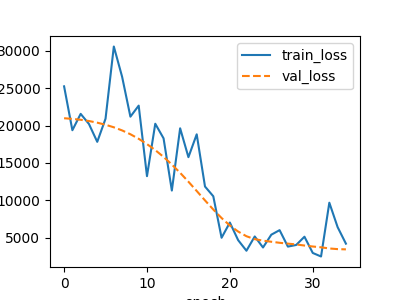

In [18]:
loss_func = nn.MSELoss()
model1 = Net()
opt = optim.Adam(model1.parameters(), lr=1.5e-2)
model_loss, model1 = fit(epochs=50, model=model1, loss_func=loss_func, opt=opt, 
                         train_ds=cir_train_ds, valid_ds=cir_valid_ds, bs=16, 
                         X_train=cir_X_train, y_train=cir_y_train, X_val=cir_X_val, y_val=cir_y_val, 
                         temp=6)
plt_curve([model_loss])

## Validation

In [19]:
cir_valid = pd.DataFrame(torch.cat((torch.from_numpy(scaler.inverse_transform(cir_X_val)), cir_y_val), 1))
cir_valid.columns = cir_data.columns
df_group(cir_valid, ['t', 'E1', 'f'], 3)
ngroups = 2

### Group 1

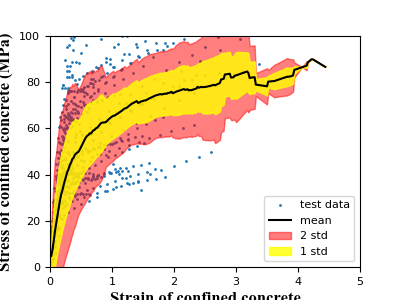

In [20]:
valid_plot(cir_valid, scaler, ['t', 'E1', 'f'], 0, ngroups, target, model1)

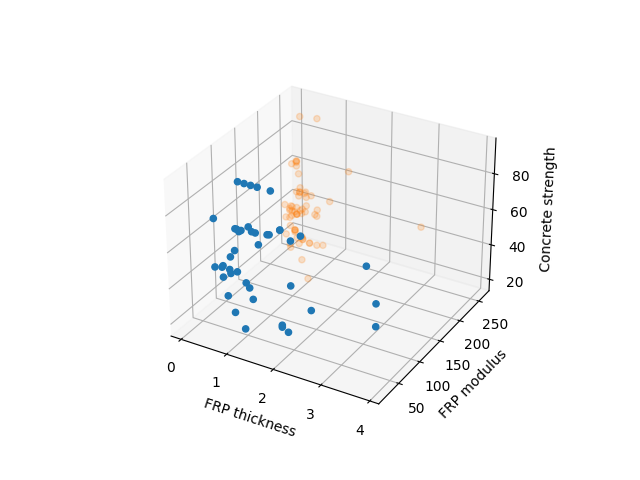

In [21]:
show_feature_space(cir_valid, 0, ngroups, ['t', 'E1', 'f'], ['FRP thickness', 'FRP modulus', 'Concrete strength'])

### Group 2

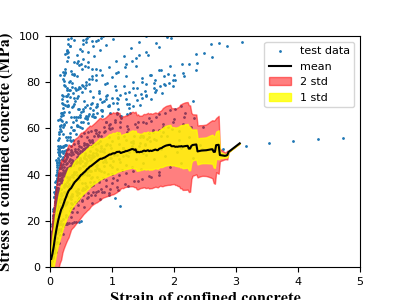

In [22]:
X = valid_plot(cir_valid, scaler, ['t', 'E1', 'f'], 1, ngroups, target, model1)

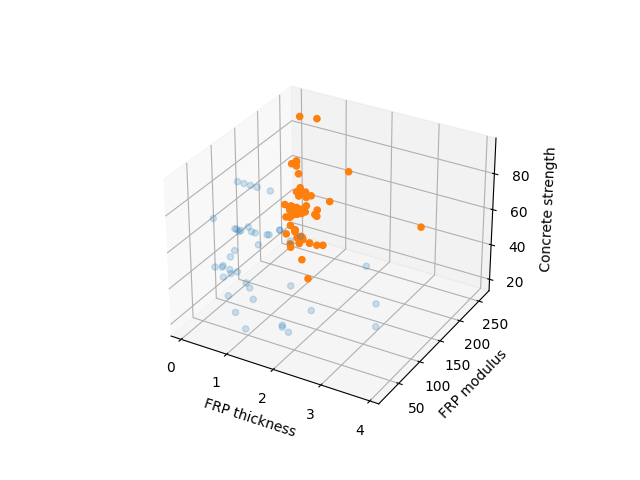

In [23]:
show_feature_space(cir_valid, 1, ngroups, ['t', 'E1', 'f'], ['FRP thickness', 'FRP modulus', 'Concrete strength'])

# FRP confined rectangular column
## Data

In [24]:
rec_data = pd.read_csv("FRPrec.csv")
rec_data_scaled, rec_scaler = scale(pp.StandardScaler(), rec_data, target_start=10, output=target)
rec_train_ds, rec_valid_ds, rec_X_train, rec_y_train, rec_X_val, rec_y_val = split_data(rec_data_scaled, target)

## Model

In [25]:
model2 = copy.deepcopy(model1)
model2.l2.requires_grad_(False)
model2.l3.requires_grad_(False)
opt2 = optim.Adam(model2.parameters(), lr=8e-3)
model_loss2, model2 = fit(epochs=50, model=model2, loss_func=loss_func, opt=opt2, 
                         train_ds=rec_train_ds, valid_ds=rec_valid_ds, bs=8, 
                         X_train=rec_X_train, y_train=rec_y_train, X_val=rec_X_val, y_val=rec_y_val, 
                         temp=10)
# plt_curve(]model_loss2)

stable


up


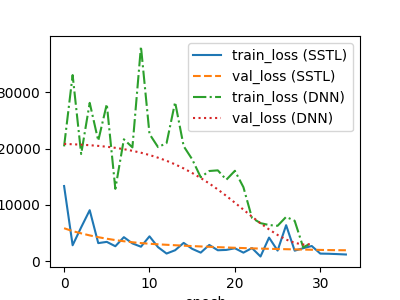

In [26]:
model22 = Net()
opt22 = optim.Adam(model22.parameters(), lr=1e-2)
model_loss22, model22 = fit(epochs=50, model=model22, loss_func=loss_func, opt=opt22, 
                         train_ds=rec_train_ds, valid_ds=rec_valid_ds, bs=8, 
                         X_train=rec_X_train, y_train=rec_y_train, X_val=rec_X_val, y_val=rec_y_val, 
                         temp=10)
plt_curve([model_loss2, model_loss22])

## Validation

In [27]:
rec_valid = pd.DataFrame(torch.cat((torch.from_numpy(rec_scaler.inverse_transform(rec_X_val)), rec_y_val), 1))
rec_valid.columns = rec_data.columns
ngroups = 3
df_group(rec_valid, ['r', 't', 'f'], ngroups)

### Group 1

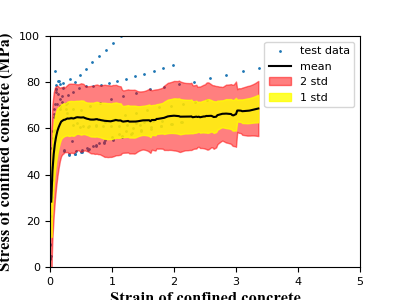

In [28]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 0, ngroups, target, model2)

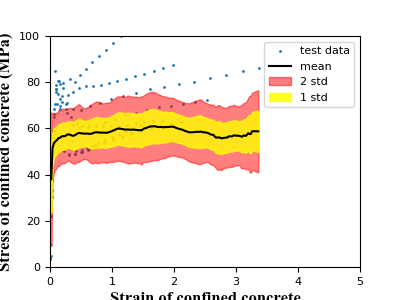

In [29]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 0, ngroups, target, model22)

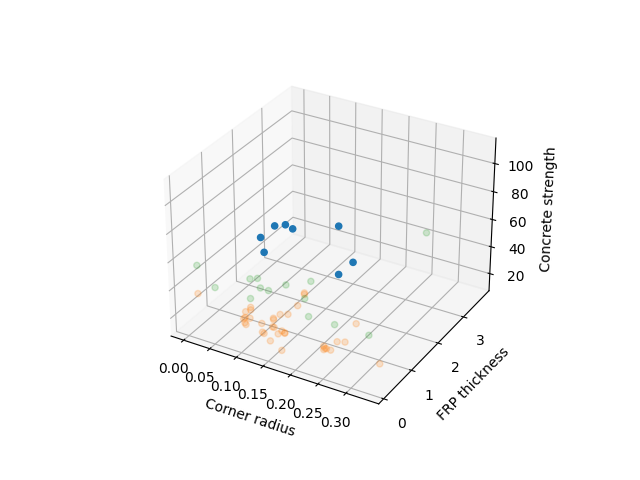

In [30]:
show_feature_space(rec_valid, 0, ngroups, ['r', 't', 'f'], ['Corner radius', 'FRP thickness', 'Concrete strength'])

### Group 2

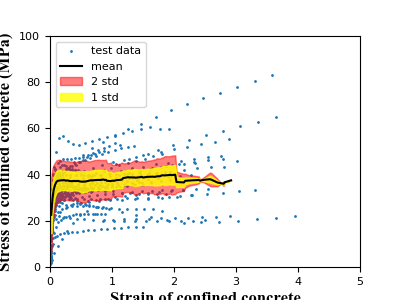

In [31]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 1, ngroups, target, model2, 2.5)

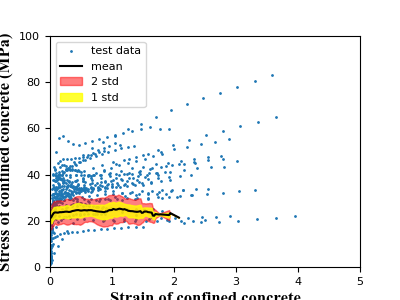

In [32]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 1, ngroups, target, model22, 2.5)

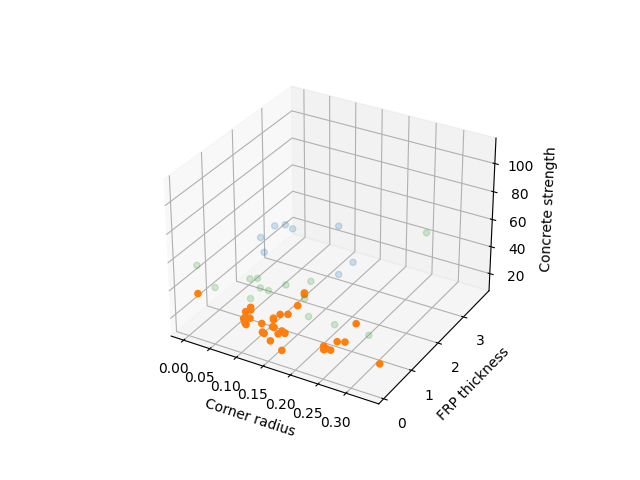

In [33]:
show_feature_space(rec_valid, 1, ngroups, ['r', 't', 'f'], ['Corner radius', 'FRP thickness', 'Concrete strength'])

### Group 3

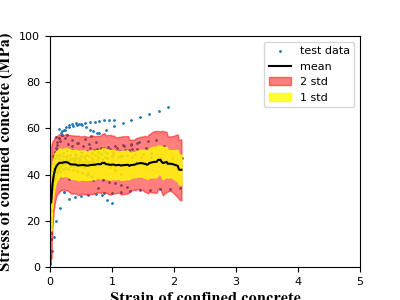

In [34]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 2, ngroups, target, model2, 1.5)

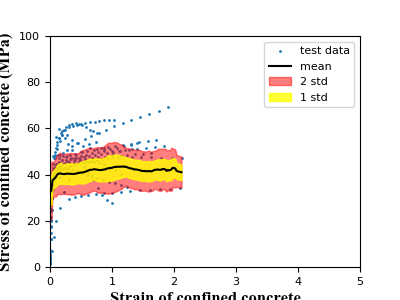

In [35]:
valid_plot(rec_valid, rec_scaler, ['r', 't', 'f'], 2, ngroups, target, model22, 2)

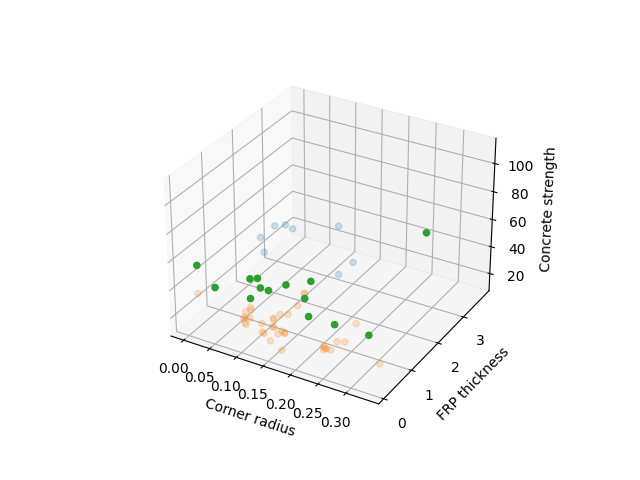

In [36]:
show_feature_space(rec_valid, 2, ngroups, ['r', 't', 'f'], ['Corner radius', 'FRP thickness', 'Concrete strength'])

# LRS FRP confined columns
## Data

In [37]:
LRS_data = pd.read_csv("FRPLRS.csv")
LRS_data_scaled, LRS_scaler = scale(pp.StandardScaler(), LRS_data, target_start=10, output=target)
LRS_train_ds, LRS_valid_ds, LRS_X_train, LRS_y_train, LRS_X_val, LRS_y_val = split_data(LRS_data_scaled, target)

## Model

In [38]:
model3 = copy.deepcopy(model1)
model3.l2.requires_grad_(False)
model3.l3.requires_grad_(False)
opt3 = optim.Adam(model3.parameters(), lr=4e-3)
model_loss3, model3 = fit(epochs=50, model=model3, loss_func=loss_func, opt=opt3, 
                         train_ds=LRS_train_ds, valid_ds=LRS_valid_ds, bs=8, 
                         X_train=LRS_X_train, y_train=LRS_y_train, X_val=LRS_X_val, y_val=LRS_y_val, 
                         temp=1)
# plt_curve(model_loss3)

stable


up


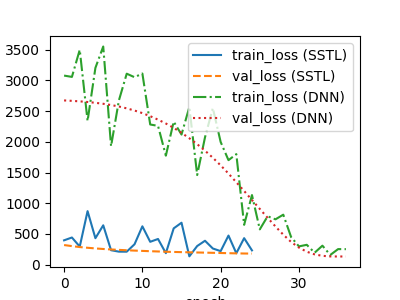

In [39]:
model33 = Net()
opt33 = optim.Adam(model33.parameters(), lr=1e-2)
model_loss33, model33 = fit(epochs=50, model=model33, loss_func=loss_func, opt=opt33, 
                         train_ds=LRS_train_ds, valid_ds=LRS_valid_ds, bs=8, 
                         X_train=LRS_X_train, y_train=LRS_y_train, X_val=LRS_X_val, y_val=LRS_y_val, 
                         temp=1)
plt_curve([model_loss3, model_loss33])

## Validation

In [40]:
LRS_valid = pd.DataFrame(torch.cat((torch.from_numpy(LRS_scaler.inverse_transform(LRS_X_val)), LRS_y_val), 1))
LRS_valid.columns = LRS_data.columns

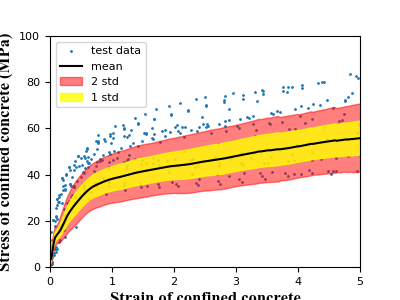

In [41]:
valid_plot(LRS_valid, LRS_scaler, ['r', 't', 'f'], 0, 1, target, model3, 1.2)

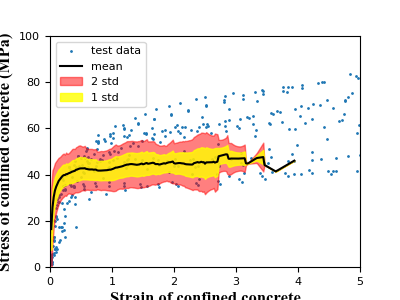

In [42]:
valid_plot(LRS_valid, LRS_scaler, ['r', 't', 'f'], 0, 1, target, model33, 1.2)

# Generalization
## Rectangular

## Rectangular 

In [43]:
def gengrid(amin, amax, bmin, bmax, cmin, cmax, scaler, df, model, target, n=20):
    x = torch.randn(n, n, n, 1, 10)
    b = np.arange(amin, amax, (amax-amin)/n)
    r = np.arange(bmin, bmax, (bmax-bmin)/n)
    t = np.arange(cmin, cmax, (cmax-cmin)/n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                x[i][j][k] = torch.Tensor([150, b[i], 2, r[j], t[k], 200, 200, 1.6, 30, 0.25])
    x = x.reshape(-1, 10)
    test_data = pd.DataFrame(x) #convert to a dataframe
    test_data_scaled = pd.DataFrame(scaler.transform(test_data.iloc[:,:10]))
    test_data_scaled.columns = df.columns[:10]
    test_data[target] = np.concatenate((model(torch.Tensor(test_data_scaled.values), False)[0].detach().numpy(), model(torch.Tensor(test_data_scaled.values), False)[1].detach().numpy()), axis=1)
    test_data.columns = df.columns
    return test_data

In [49]:
test_rec = gengrid(1, 1.5, 0, .5, 0.1, 1, rec_scaler, rec_data, model2, target)

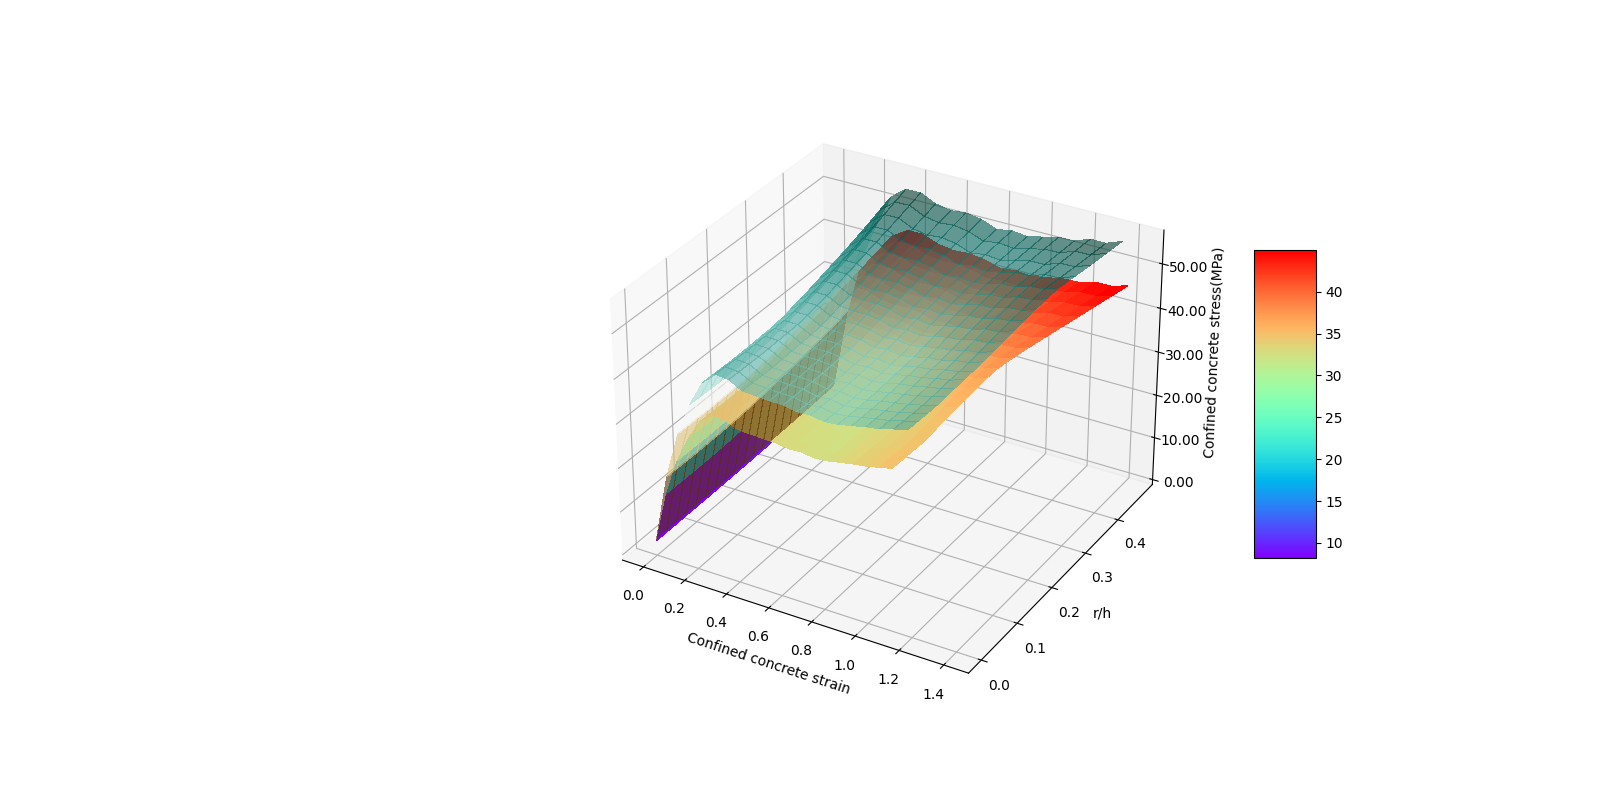

In [50]:
visual(test_rec,
       colx='ecu', 
       xlabel='Confined concrete strain', ylabel='r/h', zlabel='Confined concrete stress(MPa)', 
       target=target,
      f1='t',f2='r',f3='b')

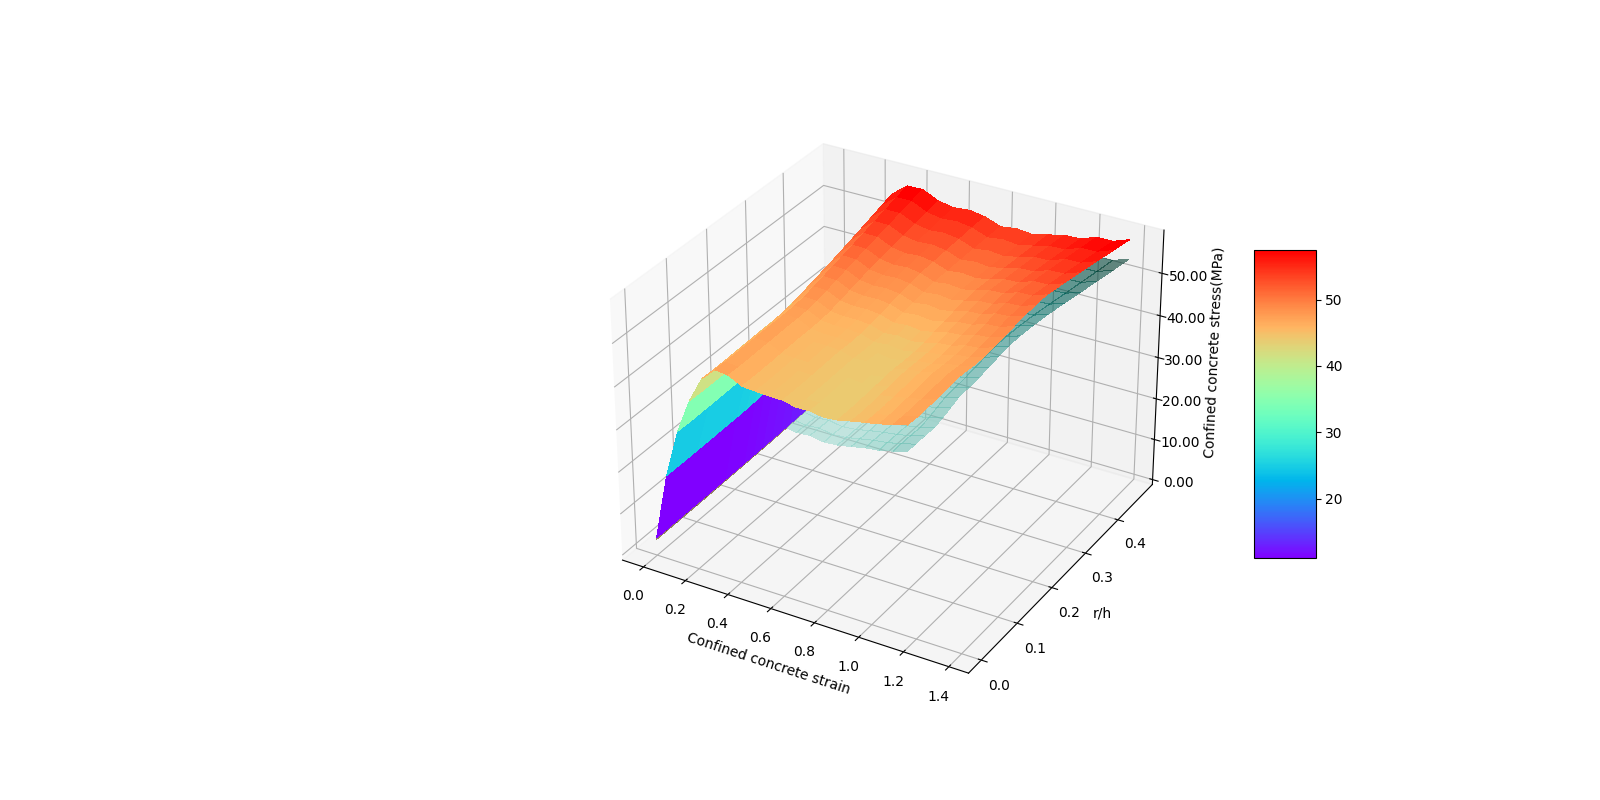

In [52]:
visual(test_rec,
       colx='ecu', 
       xlabel='Confined concrete strain', ylabel='r/h', zlabel='Confined concrete stress(MPa)', 
       target=target,
      f1='b',f2='r',f3='t')